# **Import of Libraries**

In [ ]:
import numpy as np # Linear algebra.
import pandas as pd # Data processing, CSV file I/O (e.g. pd.read_csv).
import datatable as dt # Data processing, CSV file I/O (e.g. dt.fread).

import seaborn as sns # Visualization.
import matplotlib.pyplot as plt # Visualization.

# Machine Learning block.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import make_pipeline

from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

print(f'\n[INFO] Libraries set up has been completed.')

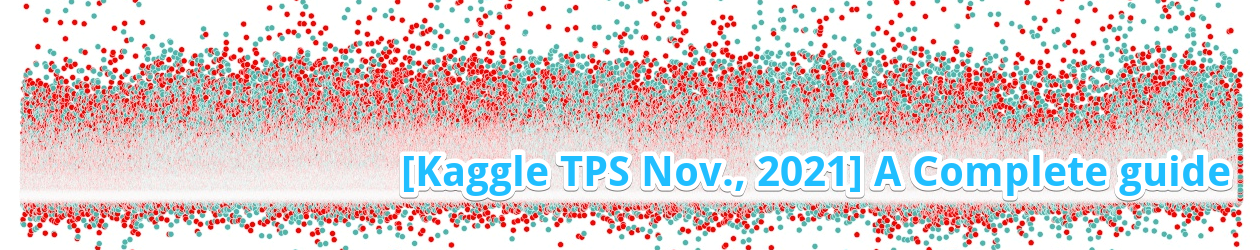

# <p style="background-color:#4DB6AC; font-family:newtimeroman; font-size:180%; text-align:center">A Complete Guide Kaggle TPS 📓</p>

>This notebook is a walk through guide for dealing with common data science competition.
>* The **objective** of this notebook is to apply step-by-step approach to solve tabular data competition.
>* The **subject** of this notebook is a classical classification task, based on "[the synthetic dataset generated using a CTGAN on a real dataset](https://www.kaggle.com/c/tabular-playground-series-nov-2021). The original dataset deals with predicting and identifying spam emails via various extracted features from the email. The features are anonymized, they have properties relating to real-world features".



## <p style="background-color:#4DB6AC; font-family:newtimeroman; font-size:120%; text-align:center">Table of Contents</p> <a href= '#Table of Contents'></a>

* [1. Data visualization 📈📉📊](#1)
* [2. Data Preprocessing 🛠](#2)
    * [2.1 Handle Missing Values](#2.1)
    * [2.2 Smoothing data / Reformating / Dropping](#2.2)
* [3. Exploratory Data Analysis 📊](#3)
* [4. Feature engineering 🔧](#4)
    * [4.1 Changing functional dependency](#4.1)
    * [4.2 Creating aggregated features](#4.2)
    * [4.3 Dropping features](#4.3)
* [5. Modeling](#5)
    * [5.1 LogisticRegression](#5.1)
    * [5.2 Linear SVC](#5.2)
    * [5.3 Gaussian Naive Bayes](#5.3)
    * [5.4 Stochastic Gradient Decent](#5.4)
    * [5.5 XGB](#5.5)
    * [5.6 * Bonus Model: TabNet](#5.6)
* [6. Conclusions](#6)
    * [6.1 ** Bonus Postprocessing](#6.1)
* [7. References](#7)

<a id='1'></a>
# <p style="background-color:#4DB6AC; font-family:newtimeroman; font-size:120%; text-align:center">1. Data visualization 📈📉📊</p>

> **Let's read the data first** (I strongly recommend using 'datatable' to for faster data reading):

In [ ]:
df_train = dt.fread('../input/tabular-playground-series-nov-2021/train.csv').to_pandas()
df_test = dt.fread('../input/tabular-playground-series-nov-2021/test.csv').to_pandas()
submission = pd.read_csv('../input/tabular-playground-series-nov-2021/sample_submission.csv')

df_train['target'] = df_train['target'].astype('int32') # Datatable reads target as bool by default.
print(f'{df_train.info()}\n\n')
df_train.head(3)

> **At first glance, the data is pretty heavy memory-wise.** 
No doubts that float64 makes it heavier. let's take a closer look at dtypes:

> **"id" and "target" columns are int64.** We do not really need "id" column. We do not really need "target" as int64.
Moreover, we can downscale float64 for the sake of faster computation. We will work on it later on. 

> **Now let's plot our target values:**

In [ ]:
df_target_count = df_train.target.value_counts()

f, axes = plt.subplots(ncols=2, figsize=(12, 3))
plt.subplots_adjust(wspace=0)

df_target_count.plot.pie(
    ax=axes[0], autopct="%.1f%%", 
    explode=(0.05, 0.05),label='', 
    title='Target Count', fontsize=16,
    colors=['#BB0000', '#4DB6AC'], 
    shadow=True, startangle=140,   
)

df_target_count.plot.barh(
    ax=axes[1],
    title='Target Count',
    fontsize=16,
    color=['#BB0000', '#4DB6AC']
)

plt.tick_params(
    axis='x',         
    which='both',      
    bottom=False,      
    labelbottom=False
)

for i, v in enumerate(df_target_count):
    axes[1].text(v, i+0.25, str(v), color='black', fontweight='bold')
    axes[1].set_xlim([1, 350000])

plt.show()

> **Good news, our classes are well balanced!**

> **Now we are going to plot some features (we go with 12) against its target values.**
>
> Additionally to the above, let's get 30000 sample for a faster run time.

In [ ]:
seed = 322
df_train_sample = df_train.sample(n=30000, random_state=seed)
df_test_sample = df_test.sample(n=30000, random_state=seed)
df_train_sample.drop(columns='id', inplace=True)
df_test_sample.drop(columns='id', inplace=True)

np.random.seed(seed) 
features_choice = np.random.choice(
    df_train_sample.keys()[1:-1], size=12, replace=False
)

df_sample_twelve = df_train_sample[sorted(features_choice.tolist()) + ['target']]
df_sample_twelve.head(3)

In [ ]:
fig, ax = plt.subplots(nrows=12, figsize=(24, 24))

for i, feature in enumerate(sorted(features_choice)):
     sns.scatterplot(
         data=df_sample_twelve,
         x=df_sample_twelve.index,
         y=feature,
         hue='target',
         palette=['red', '#4DB6AC'],
         legend=True,
         ax=ax[i]
     )
        

> **Some chosen features are on a different scale and distribution.** (e.g. some features are distributed from 0 to 5 and "f16" is on a scale from -20 to 40)

<a id='2'></a>
# <p style="background-color:#4DB6AC; font-family:newtimeroman; font-size:120%; text-align:center">2. Data Preprocessing 🛠 </p>

> **[Data preprocessing](https://en.wikipedia.org/wiki/Data_pre-processing)** can refer to manipulation or dropping of data before it is used in order to ensure or enhance performance, and is an important step in the data mining process. The phrase "garbage in, garbage out" is particularly applicable to data mining and machine learning projects.

<a id='2.1'></a>
## <p style="background-color:#4DB6AC; font-family:newtimeroman; font-size:120%; text-align:center">2.1 Handle Missing Values</p>

> **Let's check if we have any missing values:**

In [ ]:
missing_values_train = df_train.isna().any().sum()
missing_values_test = df_test.isna().any().sum()

print(f'\n[INFO] {missing_values_train} missing value(s) has/have been detected in the train dataset.')
print(f'\n[INFO] {missing_values_test} missing value(s) has/have been detected in the test dataset.')

### Missing Values, how to handle

* **Option 1: Fill NaN with Outlier or Zero**

In this specific example filling the missing value with an outlier value such as np.inf or 0 seems to be very naive. However, using values like -999, is sometimes a good idea.

* **Option 2: Fill NaN with Mean Value**

Filling NaNs with the mean value is also not sufficient and naive, and doesn't seems to be a good option.

* **Option 3: Fill NaN with Last Value with .ffill()**

Filling NaNs with the last value could be bit better.

* **Option 4: Fill NaN with Linearly Interpolated Value with .interpolate()**

Filling NaNs with the interpolated values is the best option in this small examlple but it requires knowledge of the neighouring values.

<a id='2.2'></a>
## <p style="background-color:#4DB6AC; font-family:newtimeroman; font-size:120%; text-align:center">2.2 Smoothing data / Reformating / Dropping </p>

> **Let's drop "id" column since we do not really need it:**


In [ ]:
df_train.drop(columns='id', inplace=True)
df_train.head(3)

In [ ]:
df_test.drop(columns='id', inplace=True)
df_test.head(3)

> **Having noticed float64 and int64 dtypes, we'd like to try downcast the dataset size for the sake of faster computation:**

In [ ]:
memory_train = sum(df_train.memory_usage()) / 1e6
print(f'[INFO] Memory usage train_before: {memory_train:.2f} MB.')

memory_test = sum(df_test.memory_usage()) / 1e6
print(f'[INFO] Memory usage test_before: {memory_test:.2f} MB.\n')

# Downcasting the traind dataset.
for col in df_train.columns:
    
    if df_train[col].dtype == "float64":
        df_train[col] = pd.to_numeric(df_train[col], downcast="float")
        
    if df_train[col].dtype == "int64":
        df_train[col] = pd.to_numeric(df_train[col], downcast="integer")
        
# Downcasting the test dataset.
for col in df_test.columns:
    
    if df_test[col].dtype == "float64":
        df_test[col] = pd.to_numeric(df_test[col], downcast="float")
        
    if df_test[col].dtype == "int64":
        df_test[col] = pd.to_numeric(df_test[col], downcast="integer")
        
memory_train = sum(df_train.memory_usage()) / 1e6
print(f'[INFO] Memory usage train: {memory_train:.2f} MB.')

memory_test = sum(df_test.memory_usage()) / 1e6
print(f'[INFO] Memory usage test: {memory_test:.2f} MB.')

> **We have substantially reduced the size of dataset:**
>* Memory usage train: 243.00 MB. MB against 489.60 MB; 
>* Memory usage test: 218.16 MB MB against 436.32. 
> 
> It is always a good idea to bring your dataset to a right dtype format.

<a id='3'></a>
# <p style="background-color:#4DB6AC; font-family:newtimeroman; font-size:120%; text-align:center">3. Exploratory Data Analysis 📊 </p>

> **The problem statement of this competition says that the features are anonymized.** In reality, there are not many things we can observe and make decisions on. Let's take a closer look at the distribution of the features:

In [ ]:
df_train.iloc[:, :-1].describe().T.sort_values(by='std', ascending=False)\
                     .head(15)\
                     .style.background_gradient(cmap='GnBu')\
                     .bar(subset=["mean",], color='green')\
                     .bar(subset=["max"], color='#BB0000')

> Special thanks to **EDUARDO GUTIERREZ** and his notebook for .describe method representation and styling. [**Eduardo's notebook**](https://www.kaggle.com/eduardogutierrez/tps-nov-21-exploratory-data-analysis). 
>
> **What is the distribution of the features?**
>* Features **"f2"**, **"f35"** and **"f44"** are of a higher magnitude comparing to other features;
>* The standard deviation is in the range of .05 to 1.78 if we exclude above mentioned features;
>* Some features are almost identical in terms of their scale and magnitude.

> **Let's take a closer look at the distribution of the features:**

In [ ]:
fig, axes = plt.subplots(10,10, figsize=(20, 12))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    
    sns.kdeplot(
        data=df_train_sample, ax=ax, hue='target', fill=True,
        x=f'f{idx}', palette=['#4DB6AC', 'red'], legend=idx==0
    )
 
    ax.set_xticks([]); ax.set_yticks([]); ax.set_xlabel('')
    ax.set_ylabel(''); ax.spines['left'].set_visible(False)
    ax.set_title(f'f{idx}', loc='right', weight='bold', fontsize=10)

fig.supxlabel('Probability Density Function Estimation', ha='center', fontweight='bold')
fig.tight_layout()
plt.show()

> **We have plotted Probability Density Function estimation for each feature. What does it tell us?**
>* The features are distributed differently;
>* More than half of the features are candle-like distributed (looks like Pearson Type 6 or even Poison distribution);
>* The rest of the features are bell-shaped-like (e.g., Gaussian distribution);
>* It might be a good idea to transform some of the features.

> **Let's us take a look at features correlation matrix**:

In [ ]:
corr = df_train_sample.corr()

fig, axes = plt.subplots(figsize=(20, 10))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, linewidths=.5, cmap='ocean')

plt.show()

> If we wish to label the strength of the features association, for absolute values of correlation, **0-0.19** is regarded as very weak (our example is even weaker: **0-0.10**). 

<a id='4'></a>
# <p style="background-color:#4DB6AC; font-family:newtimeroman; font-size:120%; text-align:center">4. Feature engineering 🔧</p>

> [**Feature engineering**](https://www.omnisci.com/technical-glossary/feature-engineering#:~:text=Feature%20engineering%20refers%20to%20the,machine%20learning%20or%20statistical%20modeling.) refers to the process of using domain knowledge to select and transform the most relevant variables from raw data.


<a id='4.1'></a>
## <p style="background-color:#4DB6AC; font-family:newtimeroman; font-size:120%; text-align:center">4.1 Changing functional dependency</p>

> We have made and assumption that it might be a good idea to transform some of the features. Let's try to do it for all candle-like distributed features:

In [ ]:
candles = [
    'f0','f2','f4','f9','f12','f16','f19','f20','f23','f24','f27',
    'f28','f30','f31','f32','f33','f35','f39','f42','f44','f46','f48',
    'f49','f51','f52','f53','f56','f58','f59','f60','f61','f62','f63',
    'f64','f68','f69','f72','f73','f75','f76','f78','f79','f81','f83',
    'f84','f87','f88','f89','f90','f92','f93','f94','f95','f98','f99'
]

df_candles_log_transform = df_train_sample[candles]

mask_neg = (df_candles_log_transform < 0)
mask_pos = (df_candles_log_transform > 0)

df_candles_log_transform[mask_neg] = np.log(np.abs(df_candles_log_transform)) * (-1)
df_candles_log_transform[mask_pos] = np.log(df_candles_log_transform)

In [ ]:
df_candles_log_transform.describe().T.sort_values(by='std', ascending=False)\
                     .head(15)\
                     .style.background_gradient(cmap='GnBu')\
                     .bar(subset=["mean",], color='green')\
                     .bar(subset=["max"], color='#BB0000')

> **We've been able to significantly shrink the magnitude of "f2".**
> 
> Let's plot the Probability Density Function Estimation for the transformed features:

In [ ]:
df_candles_log_transform['target'] = df_train_sample.target

fig, axes = plt.subplots(11,5, figsize=(20, 12))
axes = axes.flatten()

for col, ax in zip(candles, axes):
    
    sns.kdeplot(
        data=df_candles_log_transform, ax=ax, hue='target', fill=True,
        x=col, palette=['#4DB6AC', 'red'], legend=idx==0
    )
 
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['left'].set_visible(False)
    ax.set_title(col, loc='right', weight='bold', fontsize=10)

fig.supxlabel('Probability Density Function Estimation', ha='center', fontweight='bold')
fig.tight_layout()
plt.show()

> The distributions of the transformed features looks more bell-shaped-like but still...
> A good idea is to transform features separately, adding them into a model and monitor the model performance. It might be a very time consuming process taking into consideration not only log transformations. We will leave it as an exercise for the reader.

<a id='4.2'></a>
## <p style="background-color:#4DB6AC; font-family:newtimeroman; font-size:120%; text-align:center">4.2 Creating aggregated features</p>

> One of the naive approach to engineer features, is to aggregate them.  
> Special thanks to **RAHUL YADAV** and his notebook. [**Rahul's notebook**](https://www.kaggle.com/rahullalu/tps-nov-2021-eda-and-baseline#Approach).
>
> The problem with aggregation is that we might encounter **multicollinearity** (e.g., the high correlation of the explanatory variables). "It should be noted that the presence of multicollinearity does not mean that the model is
misspecified. You only start to talk about it when you think that it is
affecting the regression results seriously." [[1]](#8.1)
>
> Now let's create our aggregated features:


In [ ]:
agg_features = ['sum','mean','std','max','min','kurt']
features = df_train.keys().tolist()[:-1]

for ft in agg_features:
    
    class_method = getattr(pd.DataFrame, ft)
    df_train_sample[ft] = class_method(df_train_sample[features], axis=1)
    df_test_sample[ft] = class_method(df_test_sample[features], axis=1)

df_train_sample.head(3)

<a id='4.3'></a>
## <p style="background-color:#4DB6AC; font-family:newtimeroman; font-size:120%; text-align:center">4.3 Dropping features </p>

> Another good idea is to test the feature importance by dropping it and monitoring the model performance at the same time.
>
> We will do it during modeling stage.

<a id='5'></a>
# <p style="background-color:#4DB6AC; font-family:newtimeroman; font-size:120%; text-align:center">5. Modeling</p>

> Now it is modeling time. There are many models to choose from. We are going to try following ones:
>
>* Logistic Regression
>* Linear SVC
>* Gaussian Naive Bayes
>* Stochastic Gradient Decent
>* XGB
>* TabNet

### ***Helper functions***

> Special thanks to [ORMALKA](https://www.kaggle.com/ormalka) for finding "deepcopy" bug. Greatly appreciated!

In [ ]:
def print_shapes(X_train, y_train, X_valid, y_valid):
  """
  Prints shapes of train/valid splits.
  :param: X_train (numpy.ndarray)
  :param: y_train (numpy.ndarray)
  :param: X_valid(numpy.ndarray)
  :param: y_valid (numpy.ndarray)
  :return: None
  """

  print(f'\n[INFO] shape of X_train: {X_train.shape}.')
  print(f'[INFO] shape of y_train: {y_train.shape}.')
  print(f'[INFO] shape of X_valid: {X_valid.shape}.')
  print(f'[INFO] shape of y_valid: {y_valid.shape}.\n')


def auc_score(y_true, y_pred):
  """
  Prints shapes of train/valid splits.
  :param: y_true (numpy.ndarray)
  :param: y_pred (numpy.ndarray)
  :return: float
  """

  fpr, tpr, _ = roc_curve(y_true, y_pred)
  score = auc(fpr, tpr)

  return score


def train_model(x, y, clf, clf_name, xgb=False):
    """
    Trains model by using selected classifier.
    :param: x (scaled numpy.ndarray)
    :param: y (scaled numpy.ndarray)
    :param: clf (model classifier)
    :param: clf_name (str)
    :return: clf, float
    """
    
    best_clf_auc = 0

    for fold, (idx_train, idx_valid) in enumerate(skf.split(X, Y)):

            X_train, y_train = X[idx_train, :], Y[idx_train]
            X_valid, y_valid = X[idx_valid, :], Y[idx_valid]

            if fold == 0:
                print_shapes(X_train, y_train, X_valid, y_valid)
            
            if xgb:
                clf.fit(
                    X_train, y_train,
                    eval_set=[(X_train, y_train), (X_valid, y_valid)],
                    eval_metric='auc',
                    early_stopping_rounds=40,
                    verbose=100
                )
            else:
                clf.fit(X_train, y_train)

            y_pred = clf.predict_proba(X_valid)[:, 1]
            clf_auc = auc_score(y_true=y_valid, y_pred=y_pred)
            print(f'[INFO] Fold: {fold+1}. {clf_name} AUC score: {clf_auc:.6f}.')

            if clf_auc > best_clf_auc:
                best_clf = deepcopy(clf)
                best_clf_auc = clf_auc
    
    return best_clf, best_clf_auc

<a id='5.1'></a>
## <p style="background-color:#4DB6AC; font-family:newtimeroman; font-size:120%; text-align:center">5.1 Logistic Regression </p>

### ***CFG***

In [ ]:
seed = 1
epochs = 40
patience = 10
batch_size = 1024
lr = 0.02
n_folds = 5
skf = StratifiedKFold(
    n_splits=n_folds, 
    shuffle=True, 
    random_state=seed
)

### ***Dataset and Scaler***

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df_train[features])
Y = df_train.target.astype(dtype=int) # TabNet can save model only with int64.
X_test = scaler.fit_transform(df_test[features])

### ***Model***

In [ ]:
lr_cfl = LogisticRegression(solver='liblinear')
clf_name = 'Logistic Regression'
best_lr_clf, best_lr_auc = train_model(x=X, y=Y, 
                                       clf=lr_cfl, clf_name=clf_name)

> Let's take a look at the coefficients:

In [ ]:
df_coef = pd.DataFrame(features)
df_coef.columns = ['Feature']
df_coef["Coefficient"] = pd.Series(best_lr_clf.coef_[0])
df_coef.sort_values(by='Coefficient', ascending=False)

> During feature engineering stage, we have **made the assumption that dropping some of the features** could improve the model performance.
>
> Let's go fancier (we are going to use our toy 30000 sample for a faster run time):

In [ ]:
scaler = StandardScaler()
X_sample = scaler.fit_transform(df_train_sample[features])
Y_sample = df_train_sample.target.astype(dtype=int) 
X_test_sample = scaler.fit_transform(df_test_sample[features])

print(f'\n[INFO] shape of X: {X_sample.shape}.')
print(f'[INFO] shape of Y: {Y_sample.shape}.')

logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_sample, Y_sample)

y_pred_logreg = logreg.predict_proba(X_sample)[:, 1]
score = auc_score(y_true=Y_sample, y_pred=y_pred_logreg)
print(f'\n[INFO] Logistic Regression AUC score: {score:.6f}.')

In [ ]:
benchmark = 0.752058
counter = 0
for idx, ft in enumerate(features):
            
    mask = df_train[features].columns != ft
    X_train = X_sample[:, mask]
    
    if idx == 0:
        print(f'\n[INFO] shape of X_train: {X_train.shape}\n')
    
    LogisticRegression(solver='liblinear')
    logreg.fit(X_train, Y_sample)
    
    
    y_pred = logreg.predict_proba(X_train)[:, 1]
    score = auc_score(y_true=Y_sample, y_pred=y_pred)
    
    if score >= benchmark:
        auc_old = benchmark
        benchmark = score
        print(
            f'\n[INFO] Iteration #: {idx}. AUC has been increased after dropping {ft} feature.\n'
            f'[INFO] Iteration #: {idx}. AUC before: {auc_old:.6f} >>> AUC after: {benchmark:.6f}.\n'
        )
    
    if idx % 10 == 0:
        print(f'[INFO] Iteration #: {idx}.')
        
    if score >= counter:
        
        counter = score
        print(f'[INFO] Iteration #: {idx}. AUC: {counter:.6f}. Removed feature: {ft}.')

> Well done! We've been able to improve performance of the 30000 sample data set by removing 'f13' feature. 
>
> Additionally to the above, the features can be checked in pairs recursively. We are not going to do it here.

<a id='5.2'></a>
## <p style="background-color:#4DB6AC; font-family:newtimeroman; font-size:120%; text-align:center">5.2 Linear SVC</p>

### ***Model***

In [ ]:
lr_svc = LinearSVC(dual=False, random_state=seed, tol=1e-4)
lr_svc = CalibratedClassifierCV(lr_svc) 
clf_name = 'Linear SVC'

best_svc_clf, best_svc_auc = train_model(x=X, y=Y, 
                                         clf=lr_svc, clf_name=clf_name)

<a id='5.3'></a>
## <p style="background-color:#4DB6AC; font-family:newtimeroman; font-size:120%; text-align:center">5.3 Gaussian Naive Bayes</p>

### ***Model***

In [ ]:
nb_cfl = GaussianNB()
clf_name = 'Gaussian Naive Bayes'
best_nb_clf, best_nb_auc = train_model(x=X, y=Y, 
                                       clf=nb_cfl, clf_name=clf_name)

<a id='5.4'></a>
## <p style="background-color:#4DB6AC; font-family:newtimeroman; font-size:120%; text-align:center">5.4 Stochastic Gradient Decent</p>

### ***Model***

In [ ]:
sgd_cfl = SGDClassifier(loss='log')
clf_name = 'SGD'
best_sgd_clf, best_sgd_auc = train_model(x=X, y=Y, 
                                         clf=sgd_cfl, clf_name=clf_name)

<a id='5.5'></a>
## <p style="background-color:#4DB6AC; font-family:newtimeroman; font-size:120%; text-align:center">5.5 XGB</p>

### ***Model***

In [ ]:
xgb_clf = XGBClassifier(
    max_depth=8,
    learning_rate=0.01,
    n_estimators=10000,
    verbosity=1,
    silent=None,
    objective='binary:logistic',
    tree_method = 'gpu_hist',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None
)


clf_name = 'XGB'
best_xgb_clf, best_xgb_auc = train_model(x=X, y=Y, clf=xgb_clf,
                                         clf_name=clf_name, xgb=True)

<a id='5.6'></a>
## <p style="background-color:#4DB6AC; font-family:newtimeroman; font-size:120%; text-align:center">5.6 * Bonus Model: TabNet</p>

> This is a pyTorch implementation of Tabnet [[2]](#8.2) by [**Dreamquark-ai**](https://github.com/dreamquark-ai/tabnet). 
>
> TabNet uses a sequential attention mechanism to choose a subset of semantically meaningful features to process at each decision step.
> According to the paper this model outperforms XGBoost:


                   
><style type="text/css">
.tg  {border-collapse:collapse;border-color:#93a1a1;border-spacing:0;}
.tg td{background-color:#fdf6e3;border-color:#93a1a1;border-style:solid;border-width:1px;color:#002b36;
  font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:5px 15px;word-break:normal;}
.tg th{background-color:#657b83;border-color:#93a1a1;border-style:solid;border-width:1px;color:#fdf6e3;
  font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:5px 15px;word-break:normal;}
.tg .tg-6f7u{background-color:#ffffff;border-color:#002b36;font-style:italic;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-604u{background-color:#4db6ac;border-color:#002b36;text-align:center;vertical-align:top}
.tg .tg-580s{background-color:#ffffff;border-color:#002b36;font-size:14px;text-align:center;vertical-align:top}
.tg .tg-vgqm{background-color:#4db6ac;border-color:#002b36;font-size:14px;text-align:center;vertical-align:top}
.tg .tg-xd2w{background-color:#ffffff;border-color:#002b36;text-align:center;vertical-align:top}
</style>
<table align="center"class="tg">
<thead>
  <tr>
    <th class="tg-vgqm"><span style="font-weight:bold;font-style:italic;color:#000">Model</span></th>
    <th class="tg-604u"><span style="font-weight:bold;font-style:italic;color:#000">Test MSE</span></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-580s">MLP</td>
    <td class="tg-xd2w">512.62</td>
  </tr>
  <tr>
    <td class="tg-xd2w">XGBoost</td>
    <td class="tg-xd2w">490.83</td>
  </tr>
  <tr>
    <td class="tg-xd2w">LightGBM</td>
    <td class="tg-xd2w">504.76</td>
  </tr>
  <tr>
    <td class="tg-xd2w">CatBoost</td>
    <td class="tg-xd2w">489.74</td>
  </tr>
  <tr>
    <td class="tg-xd2w"><span style="font-weight:bold;font-style:italic">TabNet</span></td>
    <td class="tg-6f7u"><span style="font-weight:bold;font-style:italic">485.12</span></td>
  </tr>
    <caption>Performance for Rossmann Store Sales dataset</caption>
</tbody>
</table>

> The library provides very convinient way to fit and predict. Let's build our model:

In [ ]:
!pip install pytorch-tabnet --quiet
from pytorch_tabnet.tab_model import TabNetClassifier
print(f'\n[INFO] TabNet set up has been completed.')

### ***Model***

In [ ]:
tabnet_clf = TabNetClassifier(optimizer_params=dict(lr=lr))
best_tabnet_auc = 0

for fold, (idx_train, idx_valid) in enumerate(skf.split(X, Y)):

        X_train, y_train = X[idx_train, :], Y[idx_train]
        X_valid, y_valid = X[idx_valid, :], Y[idx_valid]

        if fold == 0:
            print_shapes(X_train, y_train, X_valid, y_valid)

        tabnet_clf.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric=['auc'],
            max_epochs=epochs,
            patience=patience,
            batch_size=batch_size, 
            virtual_batch_size=128
        )

        y_pred = tabnet_clf.predict_proba(X_valid)[:, 1]
        tabnet_auc = auc_score(y_true=y_valid, y_pred=y_pred)
        print(f'\n[INFO] Fold: {fold+1}. TabNet AUC score: {tabnet_auc:.6f}.\n')

        if tabnet_auc > best_tabnet_auc:
            best_tabnet_cfl = deepcopy(tabnet_clf)
            best_tabnet_auc = tabnet_auc

<a id='6'></a>
# <p style="background-color:#4DB6AC; font-family:newtimeroman; font-size:120%; text-align:center">6. Conclusions</p>

We have run six different models. Hyperparameters tuning and features engineering have not been used during training.
Now it is the time to rank our models based on their AUC score. 

In [ ]:
results = pd.DataFrame({
    'model': [
        'Logistic Regression', 'Linear SVC', 
        'Gaussian Naive Bayes', 'SGD',
        'XGB', 'TabNet'
    ],
    'auc_score': [
        best_lr_auc, best_svc_auc, best_nb_auc, 
        best_sgd_auc, best_xgb_auc, best_tabnet_auc
    ]
})

cell_hover = {
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: white; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #16A085; color: white;'
}

s = results.sort_values(by='auc_score', ascending=False)
s = s.style.format({'auc_score': '{:.4f}'}).hide_index()
s.set_table_styles([cell_hover, index_names, headers])

s.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: left;'},
    {'selector': 'td', 'props': 'text-align: left;'},
], overwrite=False)

s

> As it was proposed, base TabNet model outperformed all other models.
Our submission to the competition resulted in scoring 248 position of 776 on the leaderboar. The competition is still running and the result might not last long. Anyway, not bad for the first attempt. Any suggestions to improve our score or performance will be greatly appreciated.
>
> Table Style and Table rendering can be found here: [**link**](https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html).
>
> P/s If I have forgotten to reference someone's work, please, do not hesitate to leave your feedback.
Any questions, suggestions or complaints are most welcome.

In [ ]:
y_test = best_tabnet_cfl.predict_proba(X_test)[:, 1]
submission["target"] = y_test
submission.head(10)

<a id='6.1'></a>
## <p style="background-color:#4DB6AC; font-family:newtimeroman; font-size:120%; text-align:center">** Bonus Postprocessing</p>
>
>Speacial thanks to AMBROSM and the [notebook](https://www.kaggle.com/ambrosm/tpsnov21-007-postprocessing).

In [ ]:
def postprocess_separate(submission, df_test, df_original=None):
    """
    Updates the submission file so that the predictions of two sides of the hyperplane don't overlap.
    :param: submission (pd.DataFrame with columns 'id' and 'target')
    :param: df_test (pd.DataFrame competition's test data without 'id' column)
    :return: df_original : (pd.DataFramethe competition's original training data)
    From https://www.kaggle.com/ambrosm/tpsnov21-007-postprocessing
    """
    
    if df_original is None: 
        df_original = dt.fread('../input/november21/train.csv').to_pandas()
        df_original['target'] = df_original['target'].astype('int32')

    # Find the separating hyperplane for df_original, step 1
    # Use an SVM with almost no regularization
    model1 = make_pipeline(
        StandardScaler(),
        LinearSVC(C=1e5, tol=1e-7, penalty='l2', 
                  dual=False, max_iter=2000, random_state=1)
    )
    
    model1.fit(df_original.drop(columns=['id', 'target']), df_original.target)
    pure_pred = model1.predict(df_original.drop(columns=['id', 'target']))

    # model1 is not perfect: it predicts the wrong class for 1 of 600000 samples.
    # Find the separating hyperplane for df_original, step 2.
    # Fit a second SVM to a subset of the points which contains the support vectors.
    pure_pred = model1.decision_function(df_original.drop(columns=['id', 'target']))
    subset_df = df_original[(pure_pred > -5) & (pure_pred < 0.9)]
    model2 = make_pipeline(
        StandardScaler(),
        LinearSVC(C=1e5, tol=1e-7, penalty='l2', 
                  dual=False, max_iter=2000, random_state=1)
    )
               
    model2.fit(subset_df.drop(columns=['id', 'target']), subset_df.target)
    pure_pred = model2.predict(df_original.drop(columns=['id', 'target']))
    
    # model2 is perfect: it predicts the correct class for all 600000 training samples
    pure_test_pred = model2.predict(df_test.drop(columns=['target'], errors='ignore'))
    lmax, rmin = submission[pure_test_pred == 0].target.max(), submission[pure_test_pred == 1].target.min()
               
    if lmax < rmin:
        print("\n[INFO] There is no overlap. No postprocessing needed.\n")
        return
    
    # There is overlap. Remove this overlap
    submission.loc[pure_test_pred == 0, 'target'] -= lmax + 1
    submission.loc[pure_test_pred == 1, 'target'] -= rmin - 1
    print(
        submission[pure_test_pred == 0].target.min(), 
        submission[pure_test_pred == 0].target.max(),
        submission[pure_test_pred == 1].target.min(), 
        submission[pure_test_pred == 1].target.max()
    )


postprocess_separate(submission, df_test=df_test)
submission.to_csv("submission_postprocessed.csv", index=False)
submission.head()

<a id='7'></a>
# <p style="background-color:#4DB6AC; font-family:newtimeroman; font-size:120%; text-align:center">7. References</p>

<a id='8.1'></a>
<p >[1] C. Dougherty. Introduction to Econometrics 5th edition, pages 171-174, 2016.</p>
<a id='8.2'></a>
<p >[2] Arik, S. O., & Pfister, T. (2019). TabNet: Attentive Interpretable Tabular Learning. arXiv preprint arXiv:1908.07442.</p> 
